# How Many Fingers?

In this replository is a small application that uses a CNN to predict how many figers you are holding up. The application does some small image manipulation to extract the edges of your hand against a plain background. It also offers functionality to collect data for training.

Data has been collected within the application by holding up 0 to 5 fingers in the region of interest and recording images. For training ~1500 images of each case has been recorded with an additional ~600 images for validation.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
import tensorflow as tf
import numpy as np
import os

# plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


## Dataset

First let's load in the data we've collected from the program. We will use kera's `ImageDataGenerator` to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [2]:
nbatch = 128

train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_datagen  = ImageDataGenerator( rescale=1./255 )

train_gen = train_datagen.flow_from_directory(
        'images/train/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

test_gen = test_datagen.flow_from_directory(
        'images/test/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

Found 9081 images belonging to 6 classes.
Found 3632 images belonging to 6 classes.


To not bias the model towards any particular label we should have roughly equal examples of each

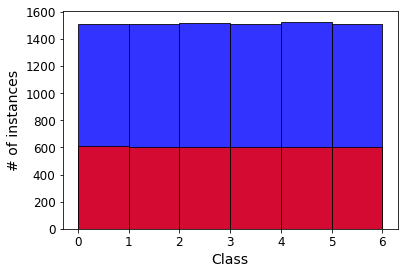

In [3]:
h1,_,_ = plt.hist(train_gen.classes, bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(test_gen.classes,  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

Next we'll do some quick checks to make sure our data are labeled correctly

In [4]:
# double check things aren't mixed up
train_gen.class_indices == test_gen.class_indices

True

(128, 300, 300, 1) (128, 6)


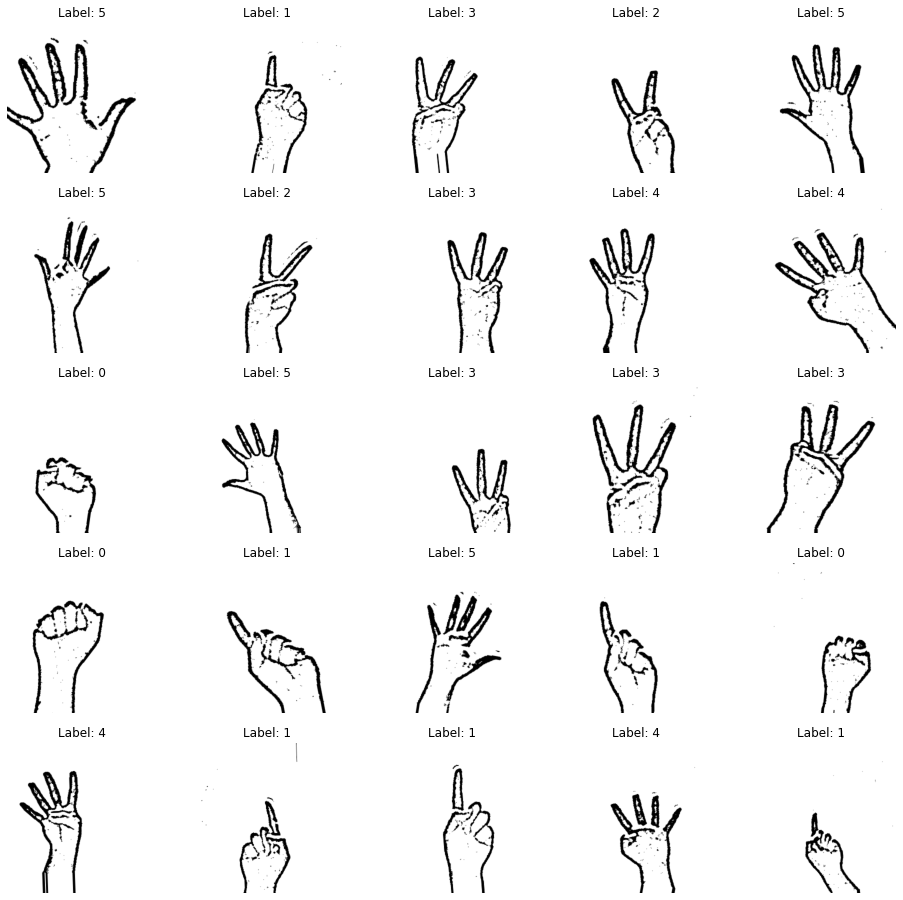

In [5]:
for X, y in train_gen:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: %d' % np.argmax(y[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

## Convolutional Neural Net

The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

In [6]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu')) # the Dense layers in Keras gives the number of output units.
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
______________________________________

In [7]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['acc'])

## Training

Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application

In [8]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_original.h5', monitor='val_loss', save_best_only=True),
]

In [9]:
# import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
with tf.device('/gpu:1'):
    history = model.fit_generator(
        train_gen,
        steps_per_epoch=71,
        epochs=40,
        validation_data=test_gen,
        validation_steps=28,
        callbacks=callbacks_list
    )


Epoch 1/40
71/71 [==============================] - 157s 2s/step - loss: 1.6373 - acc: 0.3210 - val_loss: 0.9129 - val_acc: 0.6283
Epoch 2/40
71/71 [==============================] - 63s 882ms/step - loss: 0.9310 - acc: 0.6214 - val_loss: 0.4202 - val_acc: 0.8442
Epoch 3/40
71/71 [==============================] - 66s 927ms/step - loss: 0.5119 - acc: 0.8035 - val_loss: 0.1551 - val_acc: 0.9717
Epoch 4/40
71/71 [==============================] - 66s 924ms/step - loss: 0.2885 - acc: 0.8948 - val_loss: 0.2159 - val_acc: 0.9269
Epoch 5/40
71/71 [==============================] - 66s 935ms/step - loss: 0.2213 - acc: 0.9186 - val_loss: 0.0703 - val_acc: 0.9817
Epoch 6/40
71/71 [==============================] - 67s 945ms/step - loss: 0.1389 - acc: 0.9549 - val_loss: 0.0422 - val_acc: 0.9914
Epoch 7/40
71/71 [==============================] - 67s 941ms/step - loss: 0.1113 - acc: 0.9618 - val_loss: 0.0672 - val_acc: 0.9912
Epoch 8/40
71/71 [==============================] - 66s 934ms/step - l

Text(0.5, 0, '# of epochs')

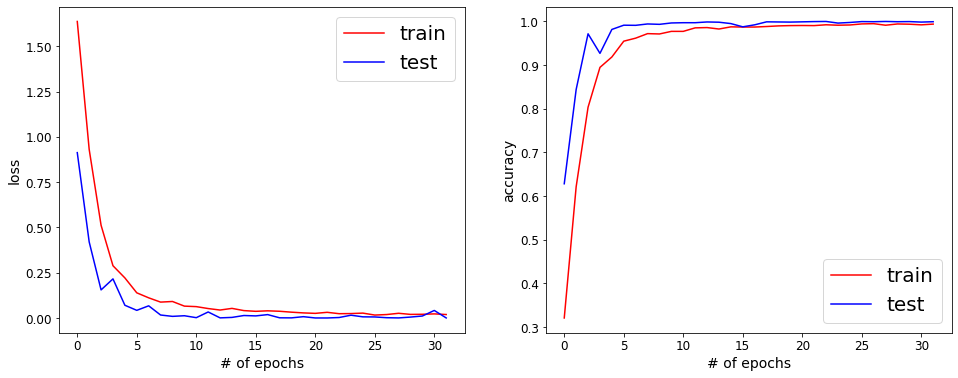

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['acc'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_acc'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

Since there is dropout being applied in the network and additional (random) augmentation being applied to the training set it is not surprising that the validation set is out-performing the training set. Nonetheless, it seems that in either case we're able to achieve near perfect ( > 99% ) accuracy.

This model is able to hence surpass human performance when the human is severely concussed or inebriated.

## Performance and Error Analysis

Our model is performing so well that there are not many cases where the model has failed for us to understand our model better. To try and probe a bit deeper I will expand the testing set and apply some augmentation.

In [13]:
test_datagen  = ImageDataGenerator( rescale=1./255, 
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_gen = test_datagen.flow_from_directory(
        'images/test/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

Found 3632 images belonging to 6 classes.


In [17]:
X_test, y_test = [], []
for ibatch, (X, y) in enumerate(test_gen):
    X_test.append(X)
    y_test.append(y)
    ibatch += 1
    if (ibatch == 5*28): break

# Concatenate everything together
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

# Get the predictions from the model and calculate the accuracy
y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' % (np.sum(match)*100/match.shape[0]))

Testing Accuracy = 99.16%


In [18]:
nomatch = (y_test != y_pred)
bad_pred = y_pred[nomatch]
bad_true = y_test[nomatch]
bad_img = X_test[nomatch]
print('%d examples of bad predictions' % bad_pred.size)

148 examples of bad predictions


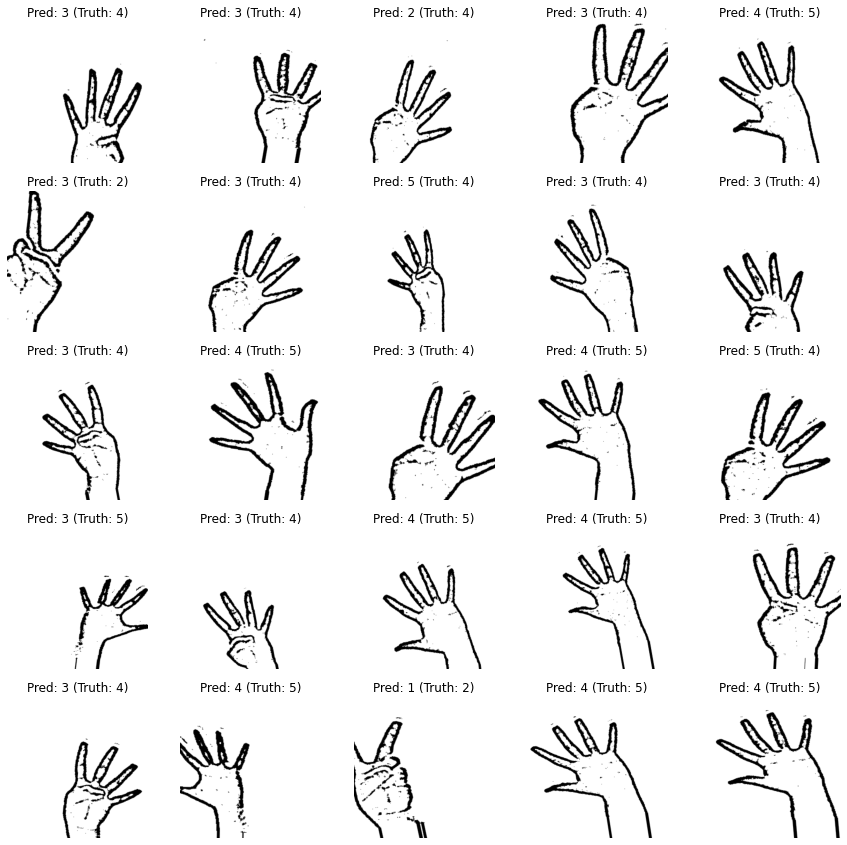

In [19]:
plt.figure(figsize=(15,15))
for i in range(min(bad_true.size,25)):
    plt.subplot(5,5,i+1)
    i+=75
    plt.title('Pred: %d (Truth: %d)' % (bad_pred[i], bad_true[i]))
    plt.axis('off')
    plt.imshow(bad_img[i][:,:,0], cmap='gray')

There are a couple examples above where fingers are moved out of the frame during augmentation and the prediction is henced flawed. These issues are likely also present during training and it's hard to fault the model for getting predictions wrong in these fringe cases. 

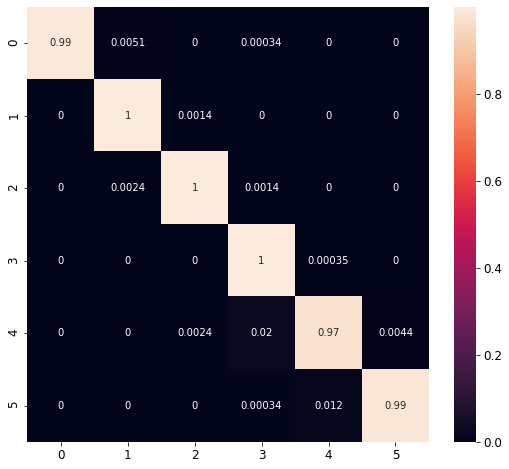

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm, annot=True);

The confusion matrix helps summarize the cases that are misclasified as shown above. In general we see that the networks seems to usually under-count the number of fingers and this is probably at least in part to the issues in augmentation that we noted previously. The network performs quite well in general but has the most trouble counting four fingers, usually confusing it for three fingers. This issue seems most prevelant when the four fingers are quite rotated to the side. As the convolutional network is not rotation invariant, this issue could possibly be improved with more data or by adjusting the model. For the purposes of this project this issue is deemed acceptable but could be improved in the future. 